# Project: Wrangling and Analyze Data

In [1]:
import sqlite3
import urllib

from configparser import ConfigParser
from io import BytesIO
from itertools import islice
from json import dump, loads
from os import environ
from pathlib import Path

import requests
import tweepy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, Image

sns.set_theme(style="darkgrid")
%matplotlib inline

<span style="color: red;">We'll store all downloaded and generated files in this directory. We create it if it doesn't exist.</span>

In [2]:
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

## Table of Contents

* [Data Gathering](#data-gathering)
* [Assessing Data](#assessing-data)
    * [twitter_archived_enhanced_df](#twitter-archived-enhanced-df)
    * [image_predictions_df](#image-predictions-df)
    * [tweet_json_txt_df](#tweet_json_txt_df)
* [Quality issues](#quality-issues)
* [Tidiness issues](#tidiness-issues)
* [Cleaning Data](#cleaning-data)
* [Storing Data](#storing-data)
* [Analyzing and Visualizing Data](#analyzing-and-visualizing-data)

## Data Gathering<a class="anchor" id="data-gathering"></a>
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

<span style="color: red;">We have to assume this file was downloaded manually, we'll first check if it exists, and if it doesn't, we'll download it and open it as if it was already on the filesystem.</span>

In [3]:
twitter_archived_enhanced_csv = data_dir / "twitter-archive-enhanced.csv"

In [4]:
if not twitter_archived_enhanced_csv.exists():
    with requests.get(
        "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv",
        stream=True
    ) as response:
        response.raise_for_status()
        with open(twitter_archived_enhanced_csv, "wb") as f:
            for chunk in response.iter_content(chunk_size=32768):  
                f.write(chunk)

<span style="color: red;">Before we open the file, let's check the first few lines to determine the proper way of open it with pandas:</span>

In [5]:
with open(twitter_archived_enhanced_csv, "r") as f:
    for line in islice(f, 5):
        print(line)

tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo

892420643555336193,,,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,,,,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None

892177421306343426,,,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",,,,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None

891815181378084864,,,20

<span style="color: red;">There's nothing out of the ordinary, so we can just use ``pandas.read_csv`` as usual:</span>

In [6]:
twitter_archived_enhanced_df = pd.read_csv(twitter_archived_enhanced_csv)

In [7]:
twitter_archived_enhanced_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

<span style="color: red;">Since we're hitting an external service, we first check if we haven't saved the loaded dataframe before. This isn't part of the wrangling process per se, but a convenience to avoid hitting external services mutiple times while running the notebook.</span>

In [8]:
image_predictions_df = None

In [9]:
image_predictions_df_pkl = data_dir / "image_predictions_df.pkl"

In [10]:
if image_predictions_df_pkl.exists():
    image_predictions_df = pd.read_pickle(image_predictions_df_pkl)

<span style="color: red;">If we haven't created the local pickled version, proceed with the expected download process:</span>

In [11]:
image_predictions_tsv_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

In [12]:
if image_predictions_df is None:
    # First we read the first few lines of the file to determine the right way of ingesting it with pandas
    with requests.get(image_predictions_tsv_url) as response:
        response.raise_for_status()
        
        for line in islice(
            filter(lambda l: bool(l), response.iter_lines(decode_unicode=True)),  # Filter out empty lines
            5                                                                     # Take only the first 5 lines
        ):
            print(line)

<span style="color: red;">As we might have guessed by the file extension, this is a tab separated file with a header, which pandas can handle without any issues if the right ``sep`` value is used:</span>

In [13]:
if image_predictions_df is None:
    with requests.get(image_predictions_tsv_url) as response:
        response.raise_for_status()
        image_predictions_df = pd.read_csv(BytesIO(response.content), sep="\t")
        image_predictions_df.to_pickle(image_predictions_df_pkl)

<span style="color: red;">Alternatively, we could have saved the file and then open it with pandas:</span>

```python
with requests.get(image_predictions_tsv_url) as response:
    response.raise_for_status()
    
    with open(data_dir / "image_predictions.tsv", "wb") as f:
        f.write(response.content)
        
    image_predictions_df = pd.read_csv(data_dir / "image_predictions.tsv", sep="\t")
```

<span style="color: red;">Or even better, let pandas handle everything for us:</span>

```python     
image_predictions_df = pd.read_csv(image_predictions_tsv_url, sep="\t")
```

In [14]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

<span style="color: red;">First we need to instantiate ``tweepy``'s ``API`` object. Notice that Twitter's credentials need to be set in ``config.ini``:</span>

In [15]:
config = ConfigParser()
config.read("config.ini");

In [16]:
assert "twitter" in config.sections()
assert {'consumer_key', 'consumer_secret', 'access_token', 'access_token_secret'} == set(config["twitter"].keys())
assert bool(config["twitter"]["consumer_key"])
assert bool(config["twitter"]["consumer_secret"])
assert bool(config["twitter"]["access_token"])
assert bool(config["twitter"]["access_token_secret"])

In [17]:
auth = tweepy.OAuthHandler(
    config["twitter"]["consumer_key"],
    config["twitter"]["consumer_secret"],
    access_token=config["twitter"]["access_token"],
    access_token_secret=config["twitter"]["access_token_secret"]
)
api = tweepy.API(
    auth,
    wait_on_rate_limit=True
)

<span style="color: red;">Given [Twitter's API rate limits](https://developer.twitter.com/en/docs/twitter-api/rate-limits), we need to compute the rate at which we can safely fetch the tweet info based on the total number of tweets. As of this writing, we can only fetch 900 tweets every 15 minutes, so I need to wait at least 1 second ((15 * 60) / 900) between each request. Given that the total number of unique tweets is:</span>

In [18]:
total_no_tweets = twitter_archived_enhanced_df.tweet_id.nunique()
print(total_no_tweets)

2356


<span style="color: red;">It'll take us about 40 minutes to fetch the tweet information.</span>

In [19]:
tweet_json_txt = data_dir / "tweet_json.txt"

In [20]:
errors = []  # We'll keep track of errors

if not tweet_json_txt.exists():
    with open(tweet_json_txt, "w") as f:
        # We're iterating of unique tweet ids in case there are duplicates on twitter_archived_enhanced_df 
        for i, tweet_id in enumerate(twitter_archived_enhanced_df.tweet_id.unique(), start=1):
            tweet = None
            
            try:
                tweet = api.get_status(
                    tweet_id,
                    tweet_mode='extended'  # Requesting extended tweets as per https://docs.tweepy.org/en/stable/extended_tweets.html#extended-mode
                )

                #
                # Print progress
                #
                clear_output(wait=True)
                print(f"{i}/{total_no_tweets}: {tweet_id}")
                
                #
                # Notice that we're using a JSONL (JSON lines) format. This makes it easier to monitor
                # the progress as we can tail tweet_json.txt while we're fetching the info.
                #
                dump(tweet._json, f)
                f.write("\n")
            except Exception as e:
                print(f"Exception raised while fetching tweet status. tweet_id: {tweet_id}, e: {e}")
                errors.append((tweet_id, e, tweet))

<span style="color: red;">Let's check how many errors were encountered during the fetch process:</span>

In [21]:
len(errors)  # It might be 0 if we skipped fetching the tweet information

0

<span style="color: red;">Let's show the first few lines of ``tweet_json.txt`` to verify it was written correctly. We've used the JSONL (JSON lines) format they're easier to work with then streaming JSON data.</span>

In [22]:
with open(tweet_json_txt, "r") as f:
    for line in islice(f, 5):  # Take only the first 5 lines
        print(line)

{"created_at": "Tue Aug 01 16:23:56 +0000 2017", "id": 892420643555336193, "id_str": "892420643555336193", "full_text": "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", "truncated": false, "display_text_range": [0, 85], "entities": {"hashtags": [], "symbols": [], "user_mentions": [], "urls": [], "media": [{"id": 892420639486877696, "id_str": "892420639486877696", "indices": [86, 109], "media_url": "http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg", "media_url_https": "https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg", "url": "https://t.co/MgUWQ76dJU", "display_url": "pic.twitter.com/MgUWQ76dJU", "expanded_url": "https://twitter.com/dog_rates/status/892420643555336193/photo/1", "type": "photo", "sizes": {"thumb": {"w": 150, "h": 150, "resize": "crop"}, "medium": {"w": 540, "h": 528, "resize": "fit"}, "small": {"w": 540, "h": 528, "resize": "fit"}, "large": {"w": 540, "h": 528, "resize": "fit"}}}]}, "extended_entities": {"media

<span style="color: red;">The first few lines are ok. Let's load all of the lines onto a list.</span>

In [23]:
tweet_json_txt_json = []
with open(tweet_json_txt, "r") as f:
    tweet_json_txt_json = [
        loads(line)
        for line in f
    ]
tweet_json_txt_json[:5]

[{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
  'id': 892420643555336193,
  'id_str': '892420643555336193',
  'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
  'truncated': False,
  'display_text_range': [0, 85],
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [],
   'media': [{'id': 892420639486877696,
     'id_str': '892420639486877696',
     'indices': [86, 109],
     'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
     'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
     'url': 'https://t.co/MgUWQ76dJU',
     'display_url': 'pic.twitter.com/MgUWQ76dJU',
     'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
     'type': 'photo',
     'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
      'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
      'small': {'w': 540, 'h': 528, 'resize': 'fit'}

<span style="color: red;">Now we can create a dataframe with ``DataFrame.from_records``:</span>

In [24]:
tweet_json_txt_df = pd.DataFrame.from_records(tweet_json_txt_json)

In [25]:
tweet_json_txt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2327 non-null   object 
 1   id                             2327 non-null   int64  
 2   id_str                         2327 non-null   object 
 3   full_text                      2327 non-null   object 
 4   truncated                      2327 non-null   bool   
 5   display_text_range             2327 non-null   object 
 6   entities                       2327 non-null   object 
 7   extended_entities              2057 non-null   object 
 8   source                         2327 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

In [26]:
tweet_json_txt_df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN


<span style="color: red;">Since we only need id, retweet count, and favorite count, let's project the rest of the columns out:</span>

In [27]:
tweet_json_txt_df = tweet_json_txt_df[["id", "retweet_count", "favorite_count"]].rename({"id": "tweet_id"}, axis=1)

## Assessing Data<a class="anchor" id="assessing-data"></a>
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### twitter_archived_enhanced_df<a class="anchor" id="twitter-archived-enhanced-df"></a>

In [28]:
twitter_archived_enhanced_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [29]:
twitter_archived_enhanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

<span style="color: red;">No missing text, ratings, names, or stages.</span>

In [30]:
twitter_archived_enhanced_df.tweet_id.duplicated().sum()  # No duplicate tweets

0

In [31]:
(~twitter_archived_enhanced_df.in_reply_to_status_id.isna()).sum()  # There are 78 replies

78

In [32]:
(~twitter_archived_enhanced_df.retweeted_status_id.isna()).sum()  # There are 181 retweets

181

<span style="color: red;">Let's filter out replies and retweets (only for assessing purposes):</span>

In [33]:
twitter_archived_enhanced_valid_df = twitter_archived_enhanced_df[
    twitter_archived_enhanced_df.in_reply_to_status_id.isna()
    & twitter_archived_enhanced_df.retweeted_status_id.isna()
]

In [34]:
twitter_archived_enhanced_valid_df.shape[0]  # We've got 2097 potentially valid tweets

2097

<span style="color: red;">Let's look for rating numerators/denominators outside of the tranditional WeRateDogs rating system. Historically, the ranking goes from 0/10 to 15/10. Let's look at numerators:</span>

In [35]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator > 15
].rating_numerator.value_counts()

84      1
24      1
88      1
144     1
26      1
121     1
44      1
60      1
45      1
80      1
99      1
50      1
204     1
1776    1
165     1
27      1
75      1
420     1
Name: rating_numerator, dtype: int64

In [36]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 84
][["tweet_id", "text"]].values

array([[820690176645140481,
        'The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd']],
      dtype=object)

In [37]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 24
][["tweet_id", "text"]].values

array([[810984652412424192,
        'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx']],
      dtype=object)

In [38]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 88
][["tweet_id", "text"]].values

array([[675853064436391936,
        'Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw']],
      dtype=object)

In [39]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 26
][["tweet_id", "text"]].values

array([[680494726643068929,
        'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']],
      dtype=object)

In [40]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 121
][["tweet_id", "text"]].values

array([[684222868335505415,
        'Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55']],
      dtype=object)

In [41]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 44
][["tweet_id", "text"]].values

array([[697463031882764288,
        "Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ"]],
      dtype=object)

In [42]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 60
][["tweet_id", "text"]].values

array([[704054845121142784,
        "Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa"]],
      dtype=object)

In [43]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 45
][["tweet_id", "text"]].values

array([[709198395643068416,
        'From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK']],
      dtype=object)

In [44]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 80
][["tweet_id", "text"]].values

array([[710658690886586372,
        "Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12"]],
      dtype=object)

In [45]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 99
][["tweet_id", "text"]].values

array([[713900603437621249,
        "Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1"]],
      dtype=object)

In [46]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 50
][["tweet_id", "text"]].values

array([[716439118184652801,
        'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq']],
      dtype=object)

In [47]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 204
][["tweet_id", "text"]].values

array([[731156023742988288,
        'Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv']],
      dtype=object)

<span style="color: red;">A joke rating but technically still valid:</span>

In [48]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 1776
][["tweet_id", "text"]].values

array([[749981277374128128,
        "This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"]],
      dtype=object)

In [49]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 165
][["tweet_id", "text"]].values

array([[758467244762497024,
        'Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE']],
      dtype=object)

In [50]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 27
][["tweet_id", "text"]].values

array([[778027034220126208,
        "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq"]],
      dtype=object)

In [51]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 75
][["tweet_id", "text"]].values

array([[786709082849828864,
        "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"]],
      dtype=object)

In [52]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_numerator == 420
][["tweet_id", "text"]].values

array([[670842764863651840,
        'After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY']],
      dtype=object)

<span style="color: red;">Now let's check the denominators. Anything that is not a 10 and does not contain multiple doggos is to be considered suspicious.</span>

In [53]:
twitter_archived_enhanced_valid_df[
    (twitter_archived_enhanced_valid_df.rating_denominator != 10) &
    (~twitter_archived_enhanced_valid_df.tweet_id.isin([
        820690176645140481, 675853064436391936, 677716515794329600, 684222868335505415, 697463031882764288,
        704054845121142784, 709198395643068416, 710658690886586372, 713900603437621249, 731156023742988288,
        758467244762497024
    ]))
].rating_denominator.value_counts()

11    2
7     1
20    1
50    1
2     1
Name: rating_denominator, dtype: int64

In [54]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_denominator == 11
][["tweet_id", "text"]].values

array([[740373189193256964,
        'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ'],
       [682962037429899265,
        'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5']],
      dtype=object)

In [55]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_denominator == 7
][["tweet_id", "text"]].values

array([[810984652412424192,
        'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx']],
      dtype=object)

In [56]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_denominator == 20
][["tweet_id", "text"]].values

array([[722974582966214656,
        'Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a']],
      dtype=object)

In [57]:
twitter_archived_enhanced_valid_df[
    twitter_archived_enhanced_valid_df.rating_denominator == 2
][["tweet_id", "text"]].values

array([[666287406224695296,
        'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv']],
      dtype=object)

<span style="color: red;">Now let's check the names:</span>

In [58]:
twitter_archived_enhanced_valid_df.name.value_counts()

None          603
a              55
Lucy           11
Charlie        11
Oliver         10
             ... 
Lenox           1
Harvey          1
Blanket         1
Burt            1
Christoper      1
Name: name, Length: 955, dtype: int64

In [59]:
twitter_archived_enhanced_valid_df[twitter_archived_enhanced_valid_df.name == "a"][["tweet_id", "text"]].values

array([[881536004380872706,
        'Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF'],
       [792913359805018113,
        'Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq'],
       [772581559778025472,
        'Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn'],
       [747885874273214464,
        'This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW'],
       [747816857231626240,
        'Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R'],
       [746872823977771008,
        'This is a carrot. We only rate dogs. Please only send in 

<span style="color: red;">Now let's check the stages:</span>

In [60]:
twitter_archived_enhanced_valid_df.doggo.value_counts()

None     2014
doggo      83
Name: doggo, dtype: int64

In [61]:
twitter_archived_enhanced_valid_df.floofer.value_counts()

None       2087
floofer      10
Name: floofer, dtype: int64

In [62]:
twitter_archived_enhanced_valid_df.pupper.value_counts()

None      1867
pupper     230
Name: pupper, dtype: int64

In [63]:
twitter_archived_enhanced_valid_df.puppo.value_counts()

None     2073
puppo      24
Name: puppo, dtype: int64

### image_predictions_df<a class="anchor" id="image-predictions-df"></a>

In [64]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [65]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [66]:
image_predictions_df.shape[0]  # There's a different number of records from twitter_archived_enhanced_df

2075

<span style="color: red;">How many dog preditions are there? Are there any rows without a dog prediction?</span>

In [67]:
(image_predictions_df.p1_dog | image_predictions_df.p2_dog | image_predictions_df.p3_dog).sum()

1751

In [68]:
((~image_predictions_df.p1_dog) & (~image_predictions_df.p2_dog) & (~image_predictions_df.p3_dog)).sum()

324

In [69]:
image_predictions_df[(~image_predictions_df.p1_dog) & (~image_predictions_df.p2_dog) & (~image_predictions_df.p3_dog)].head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False


<span style="color: red;">Are the confidence values consistent?</span>

In [70]:
image_predictions_df.p1_conf.describe()

count    2075.000000
mean        0.594548
std         0.271174
min         0.044333
25%         0.364412
50%         0.588230
75%         0.843855
max         1.000000
Name: p1_conf, dtype: float64

In [71]:
image_predictions_df.p2_conf.describe()

count    2.075000e+03
mean     1.345886e-01
std      1.006657e-01
min      1.011300e-08
25%      5.388625e-02
50%      1.181810e-01
75%      1.955655e-01
max      4.880140e-01
Name: p2_conf, dtype: float64

In [72]:
image_predictions_df.p3_conf.describe()

count    2.075000e+03
mean     6.032417e-02
std      5.090593e-02
min      1.740170e-10
25%      1.622240e-02
50%      4.944380e-02
75%      9.180755e-02
max      2.734190e-01
Name: p3_conf, dtype: float64

<span style="color: red;">Anything weird on the dog breeds?</span>

In [73]:
image_predictions_df[image_predictions_df.p1_dog].p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
Japanese_spaniel        1
Scotch_terrier          1
standard_schnauzer      1
EntleBucher             1
clumber                 1
Name: p1, Length: 111, dtype: int64

In [74]:
image_predictions_df[image_predictions_df.p2_dog].p2.value_counts()

Labrador_retriever      104
golden_retriever         92
Cardigan                 73
Chihuahua                44
Pomeranian               42
                       ... 
affenpinscher             1
Japanese_spaniel          1
Kerry_blue_terrier        1
komondor                  1
Bernese_mountain_dog      1
Name: p2, Length: 113, dtype: int64

In [75]:
image_predictions_df[image_predictions_df.p3_dog].p3.value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
Irish_wolfhound        2
affenpinscher          1
Kerry_blue_terrier     1
standard_schnauzer     1
Sussex_spaniel         1
Name: p3, Length: 116, dtype: int64

### tweet_json_txt_df<a class="anchor" id="tweet_json_txt_df"></a>

In [76]:
set(twitter_archived_enhanced_valid_df.tweet_id.values) - set(tweet_json_txt_df.tweet_id.values)  # Missing tweets

{680055455951884288,
 754011816964026368,
 759923798737051648,
 779123168116150273,
 829374341691346946,
 837366284874571778,
 844704788403113984,
 872261713294495745}

### Quality issues<a class="anchor" id="quality-issues"></a>

1. There are 78 replies and 181 retweets on ``twitter_archived_enhanced_df``. [(Solution)](#issue-11)

2. On tweets ``820690176645140481``, ``675853064436391936``, ``677716515794329600``, ``684222868335505415``, ``697463031882764288``, ``704054845121142784``, ``709198395643068416``, ``710658690886586372``, ``713900603437621249``, ``731156023742988288``, ``758467244762497024`` there are multiple doggos with unusual ratings. [(Solution)](#issue-6)

3. On tweets ``810984652412424192``, ``716439118184652801``, ``716439118184652801``, ``740373189193256964``, ``682962037429899265``, ``722974582966214656``, ``666287406224695296`` there are multiple expressions confused for ratings. [(Solution)](#issue-7)

4. On tweets ``680494726643068929``, ``778027034220126208``, ``786709082849828864`` there are fractional ratings. [(Solution)](#issue-8)

5. On tweet ``670842764863651840`` the rating is invalid as the subject is not a doggo. [(Solution)](#issue-14)

6. Although the rating on tweet ``749981277374128128`` is technically valid (1776), we consider it an outlier. [(Solution)](#issue-15)

7. Invalid name "a" on 55 tweets. [(Solution)](#issue-16)

8. There were missing tweets when fetching the retweet and favourite counts with Twitter's API. [(Solution)](#issue-12)

9. There are 324 records without a dog prediction on image_predictions_df. [(Solution)](#issue-13)

### Tidiness issues<a class="anchor" id="tidiness-issues"></a>

1. Multiple tables to represent the same observational unit: the tweet. [(Solution)](#issue-10)

2. Multiple columns for the doggo stage variable. [(Solution)](#issue-4)

3. Multiple columns to represent the breed prediction and confidence. [(Solution)](#issue-1)

4. The predictions are a string but should be a category. [(Solution)](#issue-3)

5. ``timestamp`` is a string, could be a datetime. [(Solution)](#issue-5)

6. Dog breed names could be made consitent and readable. [(Solution)](#issue-2)

7. The rating is a single variable represented in two columns. [(Solution)](#issue-9)

## Cleaning Data<a class="anchor" id="cleaning-data"></a>
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [77]:
# Make copies of original pieces of data

twitter_archived_enhanced_clean_df = twitter_archived_enhanced_df.copy()
image_predictions_clean_df = image_predictions_df.copy()
tweet_json_txt_clean_df = tweet_json_txt_df.copy()

<span style="color: red;">As suggested during the cleaning data lessons, we'll tackle the tidyness issues first as this makes the rest of the tasks simpler.</span>

### Issue #1: Multiple columns to represent the breed prediction and confidence<a class="anchor" id="issue-1"></a>

#### Define:

* <span style="color: red;">Turn ``p1``, ``p2`` and ``p3`` into a single ``prediction`` column which shows the first prediction of a dog breed or ``NaN`` if no dog breed prediction was made.</span>
* <span style="color: red;">Turn ``p1_conf``, ``p2_conf`` and ``p3_conf`` into a single ``prediction_confidence`` column which shows the confidence of the first prediction of a dog breed or ``NaN`` if no dog breed prediction was made.</span>

#### Code

In [78]:
image_predictions_clean_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1181,738184450748633089,https://pbs.twimg.com/media/Cj6O1G9UYAAIU-1.jpg,1,Bedlington_terrier,0.289471,True,standard_poodle,0.173685,True,Great_Pyrenees,0.157081,True
1902,851861385021730816,https://pbs.twimg.com/media/C8W6sY_W0AEmttW.jpg,1,pencil_box,0.662183,False,purse,0.066505,False,pillow,0.044725,False
441,674468880899788800,https://pbs.twimg.com/media/CVwx3dQXAAA0ksL.jpg,2,chow,0.526230,True,Pomeranian,0.283647,True,toy_poodle,0.067665,True
1953,863907417377173506,https://pbs.twimg.com/media/C_03NPeUQAAgrMl.jpg,1,marmot,0.358828,False,meerkat,0.174703,False,weasel,0.123485,False
1939,860563773140209665,https://pbs.twimg.com/media/C_FWL0vVwAA13N7.jpg,1,Cardigan,0.583936,True,Pembroke,0.055979,True,beagle,0.045896,True


In [79]:
(image_predictions_clean_df.p1_dog | image_predictions_clean_df.p2_dog | image_predictions_clean_df.p3_dog).sum()

1751

In [80]:
image_predictions_clean_df = pd.concat([
    image_predictions_clean_df[image_predictions_clean_df.p1_dog][["tweet_id", "jpg_url", "p1", "p1_conf"]].rename({
        "p1": "prediction", "p1_conf": "prediction_confidence"
    }, axis=1),
    image_predictions_clean_df[(~image_predictions_clean_df.p1_dog) & image_predictions_clean_df.p2_dog][["tweet_id", "jpg_url", "p2", "p2_conf"]].rename({
        "p2": "prediction", "p2_conf": "prediction_confidence"
    }, axis=1),
    image_predictions_clean_df[(~image_predictions_clean_df.p1_dog) & (~image_predictions_clean_df.p2_dog) & image_predictions_clean_df.p3_dog][["tweet_id", "jpg_url", "p3", "p3_conf"]].rename({
        "p3": "prediction", "p3_conf": "prediction_confidence"
    }, axis=1),
    image_predictions_clean_df[~(image_predictions_clean_df.p1_dog | image_predictions_clean_df.p2_dog | image_predictions_clean_df.p3_dog)][["tweet_id", "jpg_url"]]
])

In [81]:
image_predictions_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2075 non-null   int64  
 1   jpg_url                2075 non-null   object 
 2   prediction             1751 non-null   object 
 3   prediction_confidence  1751 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 81.1+ KB


In [82]:
image_predictions_clean_df.head()

,tweet_id,jpg_url,prediction,prediction_confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311


#### Test

In [83]:
for _, original_row in image_predictions_df.iterrows():
    row = image_predictions_clean_df[image_predictions_clean_df.tweet_id == original_row.tweet_id].iloc[0]
    
    if original_row.p1_dog:
        assert row.prediction == original_row.p1
        assert row.prediction_confidence == original_row.p1_conf
    elif original_row.p2_dog:
        assert row.prediction == original_row.p2
        assert row.prediction_confidence == original_row.p2_conf
    elif original_row.p3_dog:
        assert row.prediction == original_row.p3
        assert row.prediction_confidence == original_row.p3_conf
    else:
        assert np.isnan(row.prediction)
        assert np.isnan(row.prediction_confidence)

### Issue #2: Dog breed names could be made consitent and readable<a class="anchor" id="issue-2"></a>

#### Define

<span style="color: red;">Replace the underscore (``_``) character on the ``prediction`` column and capitalize each word.</span>

#### Code

In [84]:
image_predictions_clean_df["prediction"] = image_predictions_clean_df.prediction.str.replace("_", " ").str.title()

#### Test

In [85]:
image_predictions_clean_df.head()

,tweet_id,jpg_url,prediction,prediction_confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh Springer Spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German Shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian Ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature Pinscher,0.560311


In [86]:
image_predictions_clean_df.prediction.str.contains("_").sum()

0

In [87]:
image_predictions_clean_df.prediction.value_counts()

Golden Retriever        173
Labrador Retriever      113
Pembroke                 96
Chihuahua                95
Pug                      65
                       ... 
Entlebucher               1
Japanese Spaniel          1
Scotch Terrier            1
Standard Schnauzer        1
Bouvier Des Flandres      1
Name: prediction, Length: 113, dtype: int64

### Issue #3: The predictions are a string but should be a category<a class="anchor" id="issue-3"></a>

#### Define

<span style="color: red;">Cast ``prediction`` as ``category``.</span>

#### Code

In [88]:
image_predictions_clean_df["prediction"] = image_predictions_clean_df.prediction.astype("category")

#### Test

In [89]:
image_predictions_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   tweet_id               2075 non-null   int64   
 1   jpg_url                2075 non-null   object  
 2   prediction             1751 non-null   category
 3   prediction_confidence  1751 non-null   float64 
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 71.8+ KB


### Issue #4: Multiple columns for the doggo stage variable<a class="anchor" id="issue-4"></a>

#### Define

<span style="color: red;">Convert the ``doggo``, ``floofer``, ``pupper``, ``puppo`` columns onto a ``stage`` column.</span>

#### Code

In [90]:
stages = ["doggo", "floofer", "pupper", "puppo"]

<span style="color: red;">We use ``np.select`` to assign a ``stage`` value depending on each condition.</span>

In [91]:
twitter_archived_enhanced_clean_df["stage"] = np.select(
    [
        # A stage is defined (one condition per stage)
        twitter_archived_enhanced_clean_df[stage] == stage
        for stage in stages
    ], stages, default=None)

In [92]:
twitter_archived_enhanced_clean_df.stage.value_counts()

pupper     245
doggo       97
puppo       29
floofer      9
Name: stage, dtype: int64

#### Test

In [93]:
for stage in stages:
    assert twitter_archived_enhanced_clean_df[
        (twitter_archived_enhanced_clean_df.stage == stage) &
        (twitter_archived_enhanced_clean_df["stage"] != stage)
    ].empty
    
assert twitter_archived_enhanced_clean_df[
    twitter_archived_enhanced_clean_df["doggo"].isna() &
    twitter_archived_enhanced_clean_df["floofer"].isna() &
    twitter_archived_enhanced_clean_df["pupper"].isna() &
    twitter_archived_enhanced_clean_df["puppo"].isna()
].stage.isna().all()

<span style="color: red;">We drop the old columns stage columns</span>

In [94]:
twitter_archived_enhanced_clean_df = twitter_archived_enhanced_clean_df.drop(stages, axis=1)

### Issue #5: ``timestamp`` is a string, could be a datetime<a class="anchor" id="issue-5"></a>

#### Define

<span style="color: red;">Convert the ``timestamp`` column to ``datetime``.</span>

#### Code

In [95]:
twitter_archived_enhanced_clean_df["timestamp"] = pd.to_datetime(twitter_archived_enhanced_clean_df.timestamp)

#### Test

In [96]:
twitter_archived_enhanced_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Issue #6: Multiple doggo ratings on a single tweet<a class="anchor" id="issue-6"></a>

#### Define

<span style="color: red;">Drop the offending tweets.</span>

#### Code

In [97]:
twitter_archived_enhanced_clean_df[twitter_archived_enhanced_clean_df.tweet_id.isin([
    820690176645140481, 675853064436391936, 677716515794329600, 684222868335505415, 697463031882764288,
    704054845121142784, 709198395643068416, 710658690886586372, 713900603437621249, 731156023742988288,
    758467244762497024
])][["tweet_id", "text", "rating_numerator", "rating_denominator"]]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the flo...,84,70
902,758467244762497024,Why does this never happen at my front door......,165,150
1120,731156023742988288,Say hello to this unbelievably well behaved sq...,204,170
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99...,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very pre...,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro...",45,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll ...,60,50
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40...,44,40
1635,684222868335505415,Someone help the girl is being mugged. Several...,121,110
1779,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120


In [98]:
twitter_archived_enhanced_clean_df = twitter_archived_enhanced_clean_df[~twitter_archived_enhanced_clean_df.tweet_id.isin([
    820690176645140481, 675853064436391936, 677716515794329600, 684222868335505415, 697463031882764288,
    704054845121142784, 709198395643068416, 710658690886586372, 713900603437621249, 731156023742988288,
    758467244762497024
])]

#### Test

In [99]:
assert twitter_archived_enhanced_clean_df[twitter_archived_enhanced_clean_df.tweet_id.isin([
    820690176645140481, 675853064436391936, 677716515794329600, 684222868335505415, 697463031882764288,
    704054845121142784, 709198395643068416, 710658690886586372, 713900603437621249, 731156023742988288,
    758467244762497024
])].empty

### Issue #7: multiple expressions confused for ratings<a class="anchor" id="issue-7"></a>

#### Define

<span style="color: red;">When there are multiple matches on a tweet for segments that look like a rating, pick the one with a "10" as denominator.</span>

#### Code

In [100]:
twitter_archived_enhanced_clean_df[twitter_archived_enhanced_clean_df.tweet_id.isin([
    810984652412424192, 716439118184652801, 716439118184652801, 740373189193256964, 682962037429899265,
    722974582966214656, 666287406224695296
])][["tweet_id", "text", "rating_numerator", "rating_denominator"]]

,tweet_id,text,rating_numerator,rating_denominator
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
1068,740373189193256964,"After so many requests, this is Bretagne. She ...",9,11
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #Final...,50,50
1662,682962037429899265,This is Darrel. He just robbed a 7/11 and is i...,7,11
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian...,1,2


In [101]:
new_ratings_df = twitter_archived_enhanced_clean_df.text.str.extract(
    r"(?P<rating_numerator>\d+)/(?P<rating_denominator>10)"
)
new_ratings_df

,rating_numerator,rating_denominator
0,13,10
1,13,10
2,12,10
3,13,10
4,12,10
...,...,...
2351,5,10
2352,6,10
2353,9,10
2354,7,10


In [102]:
new_ratings_df.loc[
    ~new_ratings_df.isnull().any(axis=1),
    ["rating_numerator", "rating_denominator"]
] = new_ratings_df[~new_ratings_df.isnull().any(axis=1)][["rating_numerator", "rating_denominator"]].astype(int)

In [103]:
twitter_archived_enhanced_clean_df.loc[
    new_ratings_df.index,
    ["rating_numerator", "rating_denominator"]
] = new_ratings_df[["rating_numerator", "rating_denominator"]]

In [104]:
twitter_archived_enhanced_clean_df = twitter_archived_enhanced_clean_df[~(
    twitter_archived_enhanced_clean_df.rating_numerator.isna() |
    twitter_archived_enhanced_clean_df.rating_denominator.isna()
)]

#### Test

In [105]:
twitter_archived_enhanced_clean_df[twitter_archived_enhanced_clean_df.tweet_id.isin([
    810984652412424192, 716439118184652801, 716439118184652801, 740373189193256964, 682962037429899265,
    722974582966214656, 666287406224695296
])][["tweet_id", "text", "rating_numerator", "rating_denominator"]]

,tweet_id,text,rating_numerator,rating_denominator
1068,740373189193256964,"After so many requests, this is Bretagne. She ...",14,10
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,13,10
1202,716439118184652801,This is Bluebert. He just saw that both #Final...,11,10
1662,682962037429899265,This is Darrel. He just robbed a 7/11 and is i...,10,10
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian...,9,10


### Issue #8: There tweets with fractional ratings<a class="anchor" id="issue-8"></a>

#### Define

<span style="color: red;">Convert the rating numerator and denominator to float. Parse the fractional ratings properly.</span>

#### Code

In [106]:
twitter_archived_enhanced_clean_df[["rating_numerator", "rating_denominator"]] = twitter_archived_enhanced_clean_df[["rating_numerator", "rating_denominator"]].astype(float)

In [107]:
new_ratings_df = twitter_archived_enhanced_clean_df.text.str.extract(
    r"(?P<rating_numerator>\d+\.\d+)/(?P<rating_denominator>10)"
).dropna()
new_ratings_df

,rating_numerator,rating_denominator
45,13.5,10
340,9.75,10
695,9.75,10
763,11.27,10
1689,9.5,10
1712,11.26,10


In [108]:
twitter_archived_enhanced_clean_df.loc[
    new_ratings_df.index,
    ["rating_numerator", "rating_denominator"]
] = new_ratings_df[["rating_numerator", "rating_denominator"]].astype(float)

#### Test

In [109]:
twitter_archived_enhanced_clean_df[twitter_archived_enhanced_clean_df.tweet_id.isin([
    680494726643068929, 778027034220126208, 786709082849828864
])][["tweet_id", "text", "rating_numerator", "rating_denominator"]]

,tweet_id,text,rating_numerator,rating_denominator
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly...",9.75,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. ...,11.27,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of ...,11.26,10.0


### Issue #9: The rating is a single variable represented in two columns<a class="anchor" id="issue-9"></a>

#### Define

<span style="color: red;">Create a new column named ``rating`` which is ``rating_numerator`` divided by ``rating_denominator``.</span>

#### Code

In [110]:
twitter_archived_enhanced_clean_df["rating"] = twitter_archived_enhanced_clean_df["rating_numerator"] / twitter_archived_enhanced_clean_df["rating_denominator"]

In [111]:
twitter_archived_enhanced_clean_df.rating.sample(5)

1408    1.2
939     1.3
1891    1.0
2310    0.2
280     1.2
Name: rating, dtype: float64

#### Test

In [112]:
for index, row in twitter_archived_enhanced_clean_df[
    ~(twitter_archived_enhanced_clean_df.rating_numerator.isna() | twitter_archived_enhanced_clean_df.rating_denominator.isna())
].iterrows():
    assert row.rating == row.rating_numerator / row.rating_denominator

### Issue #10: Multiple tables to represent the same observational unit: the tweet<a class="anchor" id="issue-10"></a>

#### Define

<span style="color: red;">Merge all dataframes on the ``tweet_id``column to a dataframe calld ``twitter_archive_master_df``.</span>

#### Code

In [113]:
twitter_archive_master_df = pd.merge(
    twitter_archived_enhanced_clean_df,
    image_predictions_clean_df,
    on=["tweet_id"],
    how="left"
)
twitter_archive_master_df = pd.merge(
    twitter_archive_master_df,
    tweet_json_txt_clean_df,
    on=["tweet_id"],
    how="left"
)

#### Test

In [114]:
twitter_archive_master_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,rating,jpg_url,prediction,prediction_confidence,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,1.3,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NaN,NaN,6978.0,33722.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,5279.0,29251.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,3465.0,21985.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,1.3,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador Retriever,0.168086,7198.0,36817.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset,0.555712,7722.0,35202.0


In [115]:
twitter_archive_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 0 to 2339
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2340 non-null   int64              
 1   in_reply_to_status_id       74 non-null     float64            
 2   in_reply_to_user_id         74 non-null     float64            
 3   timestamp                   2340 non-null   datetime64[ns, UTC]
 4   source                      2340 non-null   object             
 5   text                        2340 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2284 non-null   object             
 10  rating_numerator            2340 non-null   float64         

### Issue #11: There are 78 replies and 181 retweets on ``twitter_archived_enhanced_df``<a class="anchor" id="issue-11"></a>

#### Define

<span style="color: red;">Drop rows where ``in_reply_to_status_id`` or ``retweeted_status_id`` are not ``NaN``. Drop the unnecessary columns.</span>

#### Code

In [116]:
twitter_archive_master_df[~(twitter_archive_master_df.in_reply_to_status_id.isna() & twitter_archive_master_df.retweeted_status_id.isna())].shape[0]

255

In [117]:
twitter_archive_master_df = twitter_archive_master_df[twitter_archive_master_df.in_reply_to_status_id.isna() & twitter_archive_master_df.retweeted_status_id.isna()]

#### Test

<span style="color: red;">We drop the unnecessary columns AFTER the test.</span>

In [118]:
twitter_archive_master_df[~(twitter_archive_master_df.in_reply_to_status_id.isna() & twitter_archive_master_df.retweeted_status_id.isna())].shape[0]

0

In [119]:
twitter_archive_master_df = twitter_archive_master_df.drop(
    [
        "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id",
        "retweeted_status_timestamp"
    ],
    axis=1
)

In [120]:
twitter_archive_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2339
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2085 non-null   int64              
 1   timestamp              2085 non-null   datetime64[ns, UTC]
 2   source                 2085 non-null   object             
 3   text                   2085 non-null   object             
 4   expanded_urls          2082 non-null   object             
 5   rating_numerator       2085 non-null   float64            
 6   rating_denominator     2085 non-null   float64            
 7   name                   2085 non-null   object             
 8   stage                  336 non-null    object             
 9   rating                 2085 non-null   float64            
 10  jpg_url                1959 non-null   object             
 11  prediction             1655 non-null   category         

### Issue #12: There were missing tweets when fetching the retweet and favourite counts with Twitter's API<a class="anchor" id="issue-12"></a>

#### Define

<span style="color: red;">Drop columns where ``retweet_count`` or ``favorite_count`` as ``NaN``.</span>

#### Code

In [121]:
twitter_archive_master_df[twitter_archive_master_df.retweet_count.isna() | twitter_archive_master_df.retweet_count.isna()].shape[0]

8

In [122]:
twitter_archive_master_df = twitter_archive_master_df[~(twitter_archive_master_df.retweet_count.isna() | twitter_archive_master_df.retweet_count.isna())]

#### Test

In [123]:
twitter_archive_master_df[twitter_archive_master_df.retweet_count.isna() | twitter_archive_master_df.retweet_count.isna()].shape[0]

0

### Issue #13: There are 324 records without a dog prediction on image_predictions_df<a class="anchor" id="issue-13"></a>

#### Define

<span style="color: red;">Drop rows where ``prediction`` is ``NaN``.</span>

#### Code

In [124]:
twitter_archive_master_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'stage', 'rating',
       'jpg_url', 'prediction', 'prediction_confidence', 'retweet_count',
       'favorite_count'],
      dtype='object')

In [125]:
twitter_archive_master_df.prediction.isna().sum()

430

In [126]:
twitter_archive_master_df = twitter_archive_master_df[~twitter_archive_master_df.prediction.isna()]

#### Test

In [127]:
twitter_archive_master_df.prediction.isna().sum()

0

### Issue #14: On tweet ``670842764863651840`` the rating is invalid as the subject is not a doggo<a class="anchor" id="issue-14"></a>

#### Define

<span style="color: red;">Drop the offending tweet.</span>

#### Code

In [128]:
twitter_archive_master_df[twitter_archive_master_df.tweet_id == 670842764863651840]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,rating,jpg_url,prediction,prediction_confidence,retweet_count,favorite_count


<span style="color: red;">The tweet has already been taken care of by another fix.</span>

#### Test

### Issue #15: Remove outlier on tweet ``749981277374128128``<a class="anchor" id="issue-15"></a>

#### Define

<span style="color: red;">Drop the offending tweet.</span>

#### Code

In [129]:
twitter_archive_master_df[twitter_archive_master_df.tweet_id == 749981277374128128]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,rating,jpg_url,prediction,prediction_confidence,retweet_count,favorite_count


#### Test

<span style="color: red;">The tweet has already been taken care of by another fix.</span>

### Issue #16: Invalid name "a" on 55 tweets<a class="anchor" id="issue-16"></a>

#### Define

<span style="color: red;">Replace ``"a"`` with ``None`` on column ``name``.</span>

#### Code

In [130]:
twitter_archive_master_df.loc[twitter_archive_master_df.name == "a", "name"] = None

#### Test

In [131]:
(twitter_archive_master_df.name == "a").sum()

0

## Storing Data<a class="anchor" id="storing-data"></a>
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

<span style="color: red;">Saving onto a CSV file is actually quite trivial:</span>

In [132]:
twitter_archive_master_df.to_csv(data_dir / "twitter_archive_master.csv", index=False)

<span style="color: red;">However, if we load this CSV again, we loose some of the column type information:</span>

In [133]:
pd.read_csv(data_dir / "twitter_archive_master.csv").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1647 non-null   int64  
 1   timestamp              1647 non-null   object 
 2   source                 1647 non-null   object 
 3   text                   1647 non-null   object 
 4   expanded_urls          1647 non-null   object 
 5   rating_numerator       1647 non-null   float64
 6   rating_denominator     1647 non-null   float64
 7   name                   1602 non-null   object 
 8   stage                  256 non-null    object 
 9   rating                 1647 non-null   float64
 10  jpg_url                1647 non-null   object 
 11  prediction             1647 non-null   object 
 12  prediction_confidence  1647 non-null   float64
 13  retweet_count          1647 non-null   float64
 14  favorite_count         1647 non-null   float64
dtypes: f

<span style="color: red;">Due to this limitation, I think it's better to use a portable and type aware format like ``feather``.</span>

In [134]:
twitter_archive_master_df.reset_index().to_feather(data_dir / "twitter_archive_master.feather")

In [135]:
pd.read_feather(data_dir / "twitter_archive_master.feather").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   index                  1647 non-null   int64              
 1   tweet_id               1647 non-null   int64              
 2   timestamp              1647 non-null   datetime64[ns, UTC]
 3   source                 1647 non-null   object             
 4   text                   1647 non-null   object             
 5   expanded_urls          1647 non-null   object             
 6   rating_numerator       1647 non-null   float64            
 7   rating_denominator     1647 non-null   float64            
 8   name                   1602 non-null   object             
 9   stage                  256 non-null    object             
 10  rating                 1647 non-null   float64            
 11  jpg_url                1647 non-null   object           

<span style="color: red;">We could have also save to a ``sqlite`` table as well.</span>

In [136]:
database = data_dir / "twitter_archive_master.sqlite"
database.unlink(missing_ok=True)

In [137]:
with sqlite3.connect(database) as connection:
    twitter_archive_master_df.to_sql(name='twitter_archive_master', con=connection)

In [138]:
with sqlite3.connect(database) as connection:
    pd.read_sql(sql="SELECT * FROM twitter_archive_master", con=connection).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  1647 non-null   int64  
 1   tweet_id               1647 non-null   int64  
 2   timestamp              1647 non-null   object 
 3   source                 1647 non-null   object 
 4   text                   1647 non-null   object 
 5   expanded_urls          1647 non-null   object 
 6   rating_numerator       1647 non-null   float64
 7   rating_denominator     1647 non-null   float64
 8   name                   1602 non-null   object 
 9   stage                  256 non-null    object 
 10  rating                 1647 non-null   float64
 11  jpg_url                1647 non-null   object 
 12  prediction             1647 non-null   object 
 13  prediction_confidence  1647 non-null   float64
 14  retweet_count          1647 non-null   float64
 15  favo

<span style="color: red;">But once again we lose the type information.</span>

## Analyzing and Visualizing Data<a class="anchor" id="analyzing-and-visualizing-data"></a>
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

<span style="color: red;">The following cells contain the exploratory work that led to the insights.</span>

In [139]:
twitter_archive_master_df.name.value_counts(dropna=False)[:10]

None       390
None        45
Cooper      10
Charlie      9
Lucy         9
Tucker       9
Oliver       9
Penny        8
Sadie        7
the          7
Name: name, dtype: int64

In [140]:
twitter_archive_master_df.rating.mean()

1.0820752884031573

In [141]:
twitter_archive_master_df.rating.std()

0.17777543390270223

In [142]:
np.percentile(twitter_archive_master_df.rating, [25, 50, 75])

array([1. , 1.1, 1.2])

In [143]:
twitter_archive_master_df.rating.min(), twitter_archive_master_df.rating.max()

(0.0, 1.4)

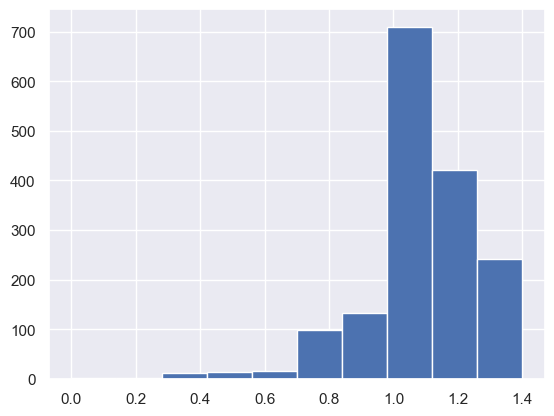

In [144]:
twitter_archive_master_df.rating.hist();

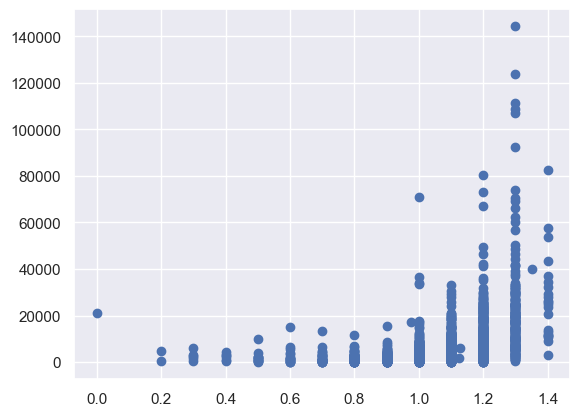

In [145]:
plt.scatter(
    twitter_archive_master_df.rating,
    twitter_archive_master_df.favorite_count
);

In [146]:
twitter_archive_master_df.rating.corr(twitter_archive_master_df.favorite_count)

0.4112524328126853

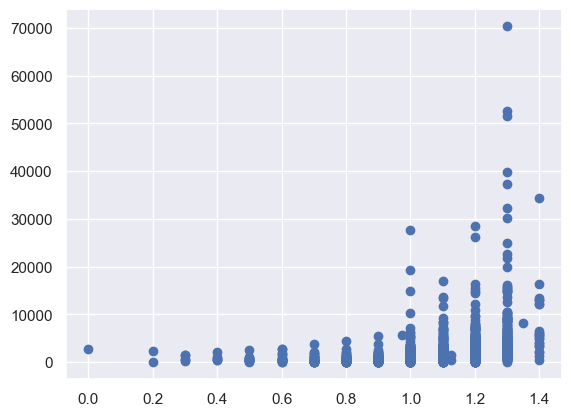

In [147]:
plt.scatter(
    twitter_archive_master_df.rating,
    twitter_archive_master_df.retweet_count
);

In [148]:
twitter_archive_master_df.rating.corr(twitter_archive_master_df.favorite_count)

0.4112524328126853

In [149]:
twitter_archive_master_df.prediction.value_counts()[:10]

Golden Retriever      154
Labrador Retriever    100
Pembroke               94
Chihuahua              90
Pug                    62
Toy Poodle             49
Chow                   47
Pomeranian             41
Samoyed                41
Malamute               33
Name: prediction, dtype: int64

In [150]:
twitter_archive_master_df.groupby("prediction").rating.mean().sort_values(ascending=False)[:10]

prediction
Bouvier Des Flandres    1.300000
Saluki                  1.250000
Briard                  1.233333
Tibetan Mastiff         1.225000
Border Terrier          1.214286
Silky Terrier           1.200000
Standard Schnauzer      1.200000
Irish Setter            1.175000
Gordon Setter           1.175000
Samoyed                 1.173171
Name: rating, dtype: float64

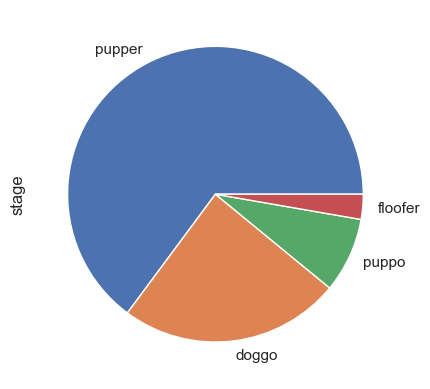

In [151]:
twitter_archive_master_df.stage.value_counts().plot(kind="pie");

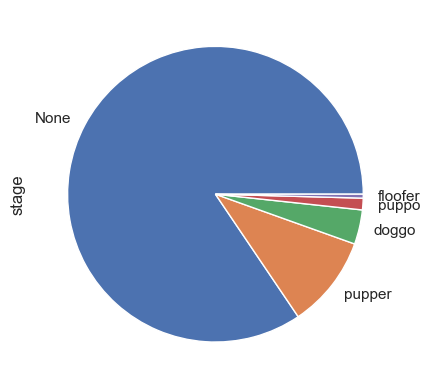

In [152]:
twitter_archive_master_df.stage.value_counts(dropna=False).plot(kind="pie");

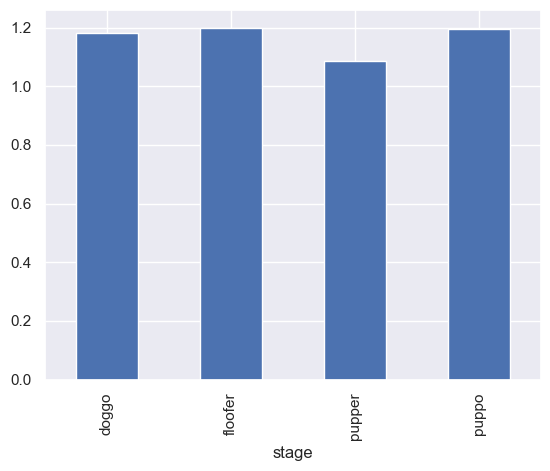

In [153]:
twitter_archive_master_df.groupby("stage").rating.mean().plot(kind="bar");

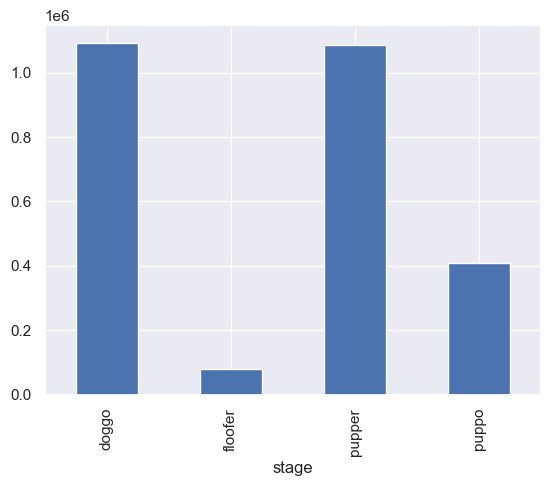

In [154]:
twitter_archive_master_df.groupby("stage").favorite_count.sum().plot(kind="bar");

### Insights:

1. Most ratings are over 10/10 (1.0)

2. Golden retrievers are the most popular breed

3. There's a slight correlation between rating and favorite and retweet counts

4. All stages are evenly rated.

5. All doggos are good doggos.

#### Insight: Most ratings are over 10/10 (1.0)

<span style="color: red;">The "Average Rating" histogram, as well as the 5 number summary clearly shows that most ratings are over 1.0, which means (assuming that all valid ratings have a 10 as denominator) that most ratings are over 10/10. We used ``twitter_archive_master_df.rating`` for this insight, which was computed dividing the ``rating_numerator`` column over the ``rating_denominator`` column. In turn, this columns, which were originally provided, required some cleaning as they were invalid ratings (due to pattern matching) as well as some outliers. </span>

In [155]:
twitter_archive_master_df.rating.mean()  # mean

1.0820752884031573

In [156]:
twitter_archive_master_df.rating.std()  # standard deviation

0.17777543390270223

In [157]:
np.percentile(twitter_archive_master_df.rating, [25, 50, 75])  # quartiles

array([1. , 1.1, 1.2])

In [158]:
twitter_archive_master_df.rating.min(), twitter_archive_master_df.rating.max()  # range

(0.0, 1.4)

#### Insight: Golden retrievers are the most popular breed

<span style="color: red;">The following ranking (as well as the chart "Popular Breed Predition" included in the visualizations section) shows the 10 most propular (predicted) breeds amongst the rated tweets. The chart ""</span>

In [159]:
twitter_archive_master_df.prediction.value_counts()[:10]

Golden Retriever      154
Labrador Retriever    100
Pembroke               94
Chihuahua              90
Pug                    62
Toy Poodle             49
Chow                   47
Pomeranian             41
Samoyed                41
Malamute               33
Name: prediction, dtype: int64

<span style="color: red;">The ``prediction`` column came from a consolidation of the ``p1``, ``p2``, and ``p3`` columns from the ``image_predictions.tsv`` file. I select the first column that predicted a dog breed for the ``prediction`` column. Afterwards we cleaned up the strings to make them readable, and turned them into a category. If you need a reason for why this breed is so popular, just check the visualization section.</span>

#### Insight: There's a slight correlation between rating and favorite and retweet counts

<span style="color: red;">The following correlation factors, shows there's a slight correlation between ``rating`` and ``favorite_count`` and ``retweet_count`` columns. These last two were missing from the original CSV file and had to be fetched from Twitter's API. Not much cleaning was needed, but there were a handful of deleted tweets for which we couldn't get these values and were dropped eventually.</span>

In [160]:
twitter_archive_master_df.rating.corr(twitter_archive_master_df.favorite_count)

0.4112524328126853

In [161]:
twitter_archive_master_df.rating.corr(twitter_archive_master_df.retweet_count)

0.3117353235682869

<span style="color: red;">The "Rating vs. Favorite Count" and "Rating vs. Retweet Count" scatter plots are consistent with these correlation factors.</span>

#### Insight: All stages are evenly rated

<span style="color: red;">The "Stage Rating Avergage" clearly shows that all stages are similarily rated (on average). The ``stage``  column is a combination of the columns ``doggo``, ``pupper``, ``puppo`` and ``fluffer``  from ``twitter-archive-enhanced.csv``. When each column had a value (with the same string as the name of the column) we took that as the ``stage`` of the individual.</span>

#### Insight: All doggos are good doggos

<span style="color: red;">Juss a fact of life.</span>

### Visualization

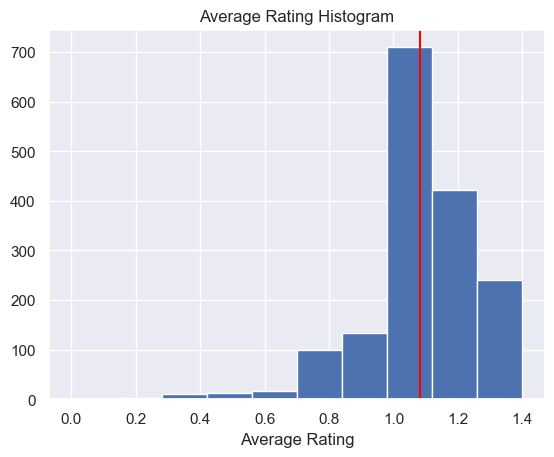

In [162]:
plt.hist(twitter_archive_master_df.rating);
plt.xlabel('Average Rating')
plt.title('Average Rating Histogram')
plt.axvline(twitter_archive_master_df.rating.mean(), color="red");

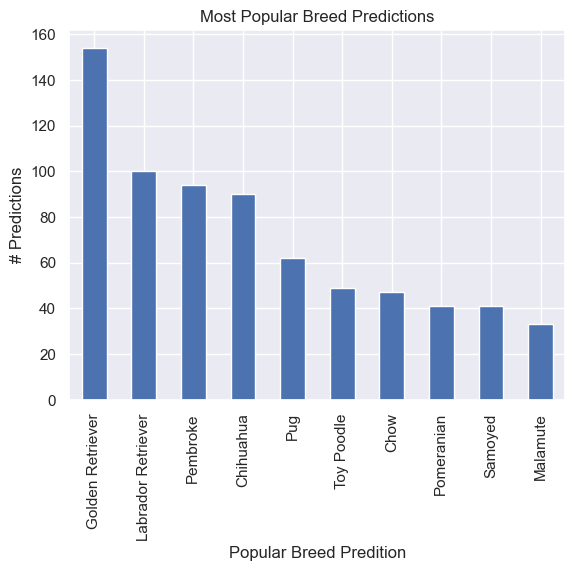

In [163]:
twitter_archive_master_df.prediction.value_counts()[:10].plot(kind="bar");
plt.xlabel('Popular Breed Predition');
plt.ylabel('# Predictions');
plt.title('Most Popular Breed Predictions');

In [164]:
twitter_archive_master_df[twitter_archive_master_df.prediction == "Golden Retriever"].jpg_url.sample(4)

482    https://pbs.twimg.com/media/C04taUjWIAA6Mo4.jpg
84     https://pbs.twimg.com/media/DCnll_dUQAAkBdG.jpg
115    https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg
47     https://pbs.twimg.com/media/DEF2-_hXoAAs62q.jpg
Name: jpg_url, dtype: object

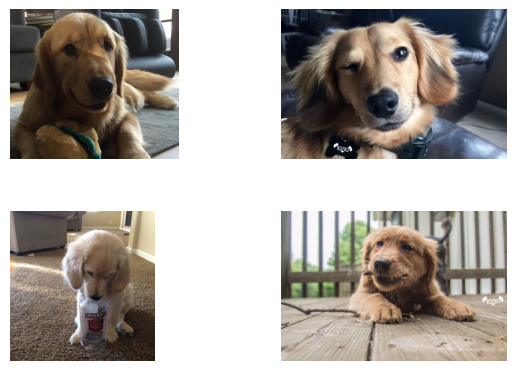

In [165]:
urls = twitter_archive_master_df[twitter_archive_master_df.prediction == "Golden Retriever"].jpg_url.sample(4)
images = [
    plt.imread(urllib.request.urlopen(url), format="jpg")
    for url in urls
]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True) ;
ax1.imshow(images[0]);
ax1.axis('off');
ax2.imshow(images[1]);
ax2.axis('off');
ax3.imshow(images[2]);
ax3.axis('off');
ax4.imshow(images[3]);
ax4.axis('off');

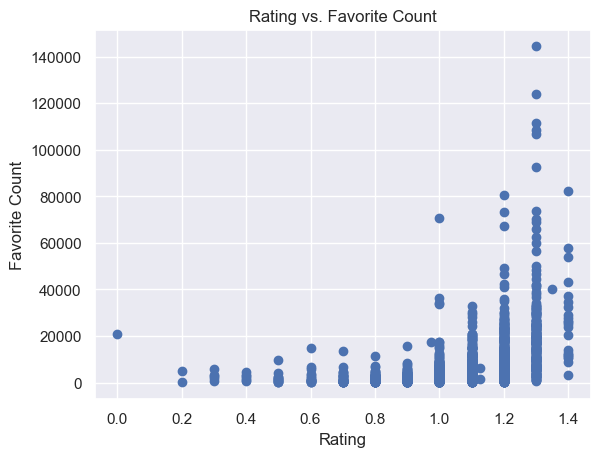

In [166]:
plt.scatter(
    twitter_archive_master_df.rating,
    twitter_archive_master_df.favorite_count
);
plt.xlabel('Rating');
plt.ylabel('Favorite Count');
plt.title('Rating vs. Favorite Count');

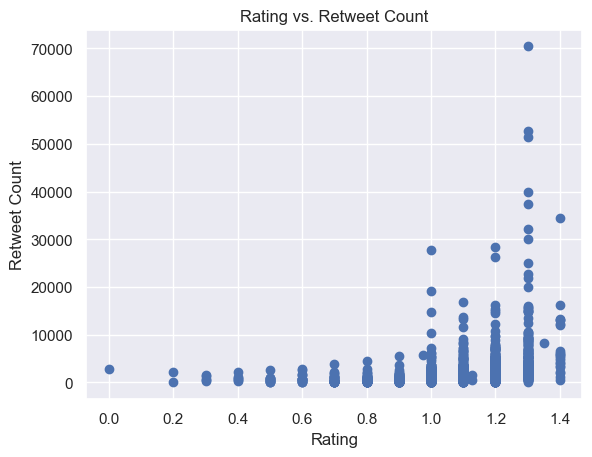

In [167]:
plt.scatter(
    twitter_archive_master_df.rating,
    twitter_archive_master_df.retweet_count
);
plt.xlabel('Rating');
plt.ylabel('Retweet Count');
plt.title('Rating vs. Retweet Count');

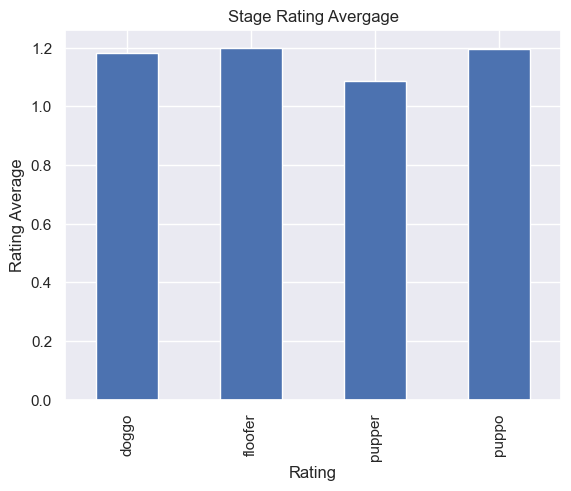

In [168]:
twitter_archive_master_df.groupby("stage").rating.mean().plot(kind="bar");
plt.xlabel('Rating');
plt.ylabel('Rating Average');
plt.title('Stage Rating Avergage');